In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Visualization and Summary
Let us first see clean the data and visualize the daily price and returns.

In [2]:
df = pd.read_csv('../data/price.csv', index_col=0, parse_dates=True)
df.describe()

,SPY,TLT
count,2618.000000,2618.000000
mean,322.244270,105.853171
std,123.736111,16.496553
min,155.869797,77.348839
25%,216.193882,94.538912
50%,286.167923,100.843990
75%,413.085510,117.770576
max,609.290466,149.759109


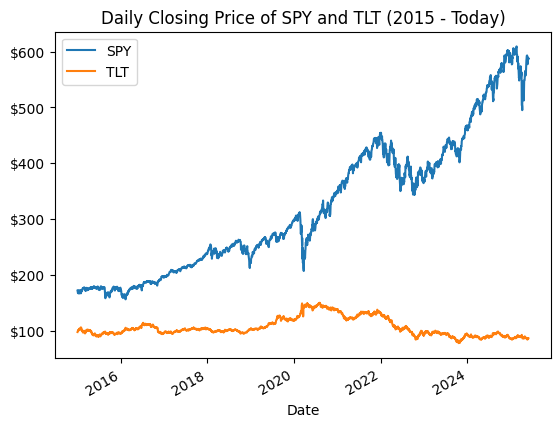

In [3]:
from matplotlib import ticker
ax = df.plot(title='Daily Closing Price of SPY and TLT (2015 - Today)')
ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('$%d'))

In [4]:
log_returns = np.log(df).diff()
log_returns.describe()

,SPY,TLT
count,2617.000000,2617.000000
mean,0.000470,-0.000047
std,0.011434,0.009622
min,-0.115886,-0.069010
25%,-0.003732,-0.005875
50%,0.000599,0.000350
75%,0.005946,0.005638
max,0.099863,0.072503


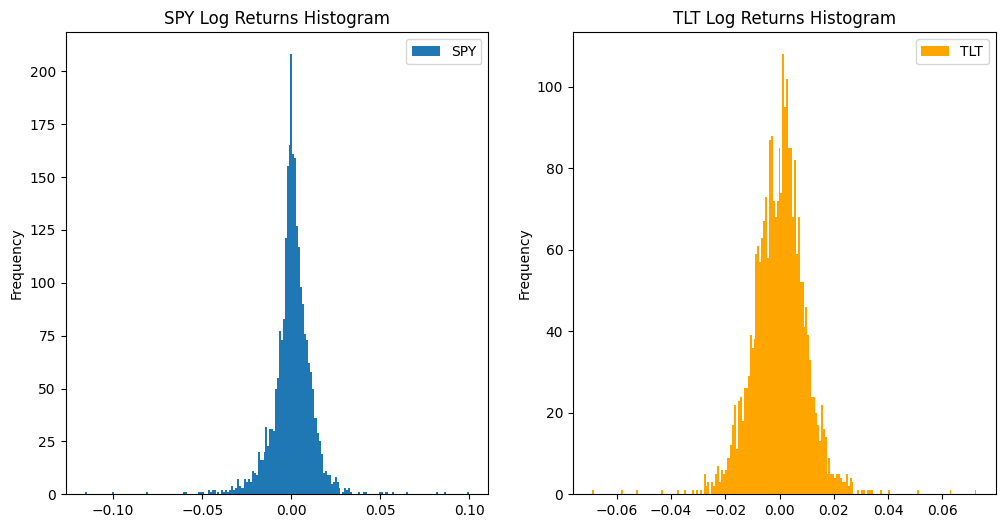

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

log_returns['SPY'].plot.hist(ax=ax[0], bins=200, label='SPY')
ax[0].set_title('SPY Log Returns Histogram')

log_returns['TLT'].plot.hist(ax=ax[1], bins=200, label='TLT', color='orange')
ax[1].set_title('TLT Log Returns Histogram')

ax[0].legend()
ax[1].legend();

# Fitted Distributions
We'll now fit the log return of each ticker with a normal distribution and a t-distribution and check the fit.

In [23]:
import scipy.stats as stats

def fit_log_returns(r: pd.DataFrame, ticker_name: str):
    """
    Analyze marginal distribution of returns for a single ticker:
    - Histogram + fitted Normal PDF
    - Histogram + fitted Student-t PDF
    - Q-Q plot for Normal
    - Q-Q plot for Student-t
    - KS test p-values
    """
    r = r[ticker_name].dropna()
    
    # Fit Normal
    mu, sigma = stats.norm.fit(r)
    
    # Fit Student-t
    df_t, loc_t, scale_t = stats.t.fit(r)
    
    fig, ax = plt.subplots(2, 2, figsize=(12, 8))
    # Normal Q-Q plot
    stats.probplot(r, dist=stats.norm, sparams=(mu, sigma), plot=ax[0, 1])
    ax[0, 1].set_title(f'{ticker_name} Normal Q-Q')
    
    # Student-t Q-Q plot
    stats.probplot(r, dist=stats.t, sparams=(df_t, loc_t, scale_t), plot=ax[1, 1])
    ax[1, 1].set_title(f'{ticker_name} Student-t Q-Q')
    
    # Plot histogram + normal PDF
    x = np.linspace(r.min(), r.max(), 500)
    pdf_normal = stats.norm.pdf(x, mu, sigma)
    ax[0, 0].hist(r, bins=200, density=True)
    ax[0, 0].plot(x, pdf_normal, 'r-', lw=2, label=f'Normal PDF\nμ={mu:.4f}, σ={sigma:.4f}')
    ax[0, 0].legend()
    ax[0, 0].set_title(f'{ticker_name} Fitted Normal Distribution')
    
    # Plot histogram + student-t PDF
    pdf_t = stats.t.pdf(x, df_t, loc_t, scale_t)
    ax[1, 0].hist(r, bins=200, density=True)
    ax[1, 0].plot(x, pdf_t, 'b-', lw=2, label=f'Student-t PDF\nν={df_t:.2f}, μ={loc_t:.4f}, σ={scale_t:.4f}')
    ax[1, 0].legend()
    ax[1, 0].set_title(f'{ticker_name} Fitted Student-t Distribution')
    
    fig.tight_layout(h_pad=3)
    plt.show()
    
    # KS tests
    ks_normal = stats.kstest(r, 'norm', args=(mu, sigma))
    ks_t = stats.kstest(r, 't', args=(df_t, loc_t, scale_t))
    
    print(f'{ticker_name} Normal KS p-value: {ks_normal.pvalue}')
    print(f'{ticker_name} Student-t KS p-value: {ks_t.pvalue}')
    
    return {
        "normal": {"mu": mu, "sigma": sigma, "ks_pvalue": ks_normal.pvalue},
        "student_t": {"df": df_t, "loc": loc_t, "scale": scale_t, "ks_pvalue": ks_t.pvalue}
    }

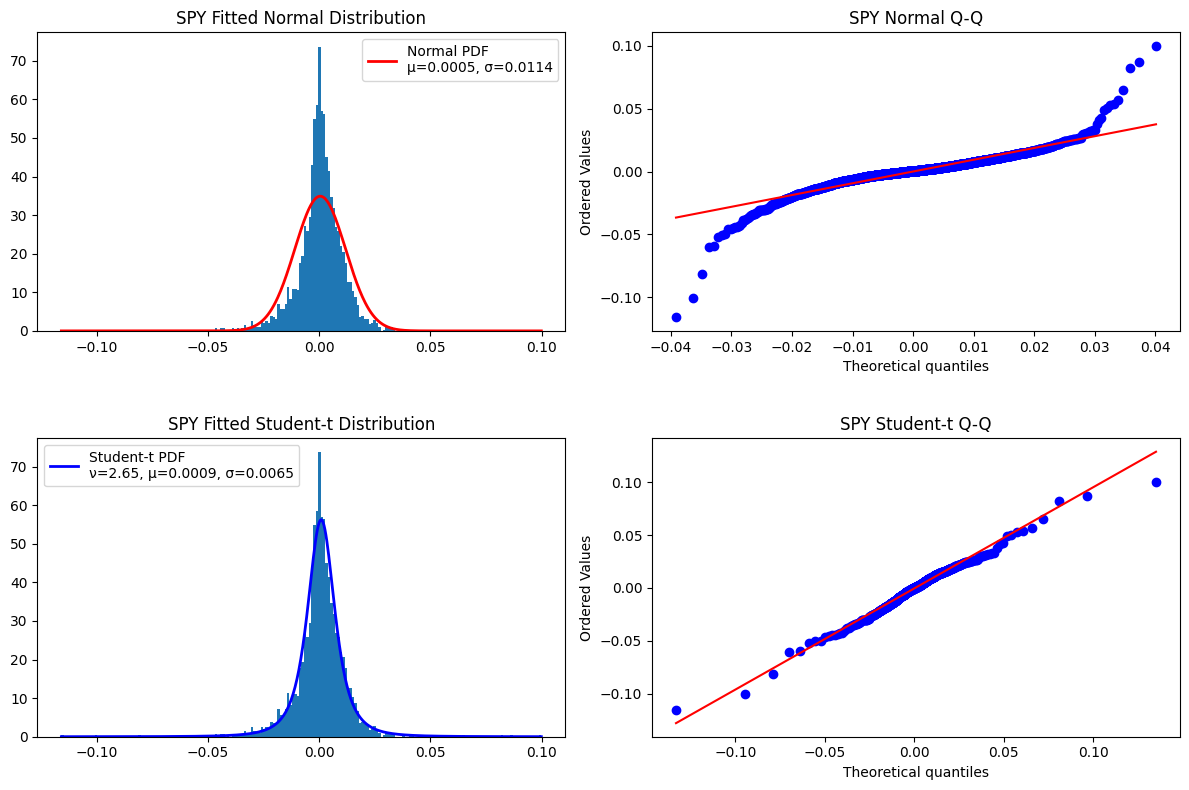

SPY Normal KS p-value: 4.45509732173947e-27
SPY Student-t KS p-value: 0.07628571922887895


In [24]:
fit_log_returns(log_returns, ticker_name='SPY');

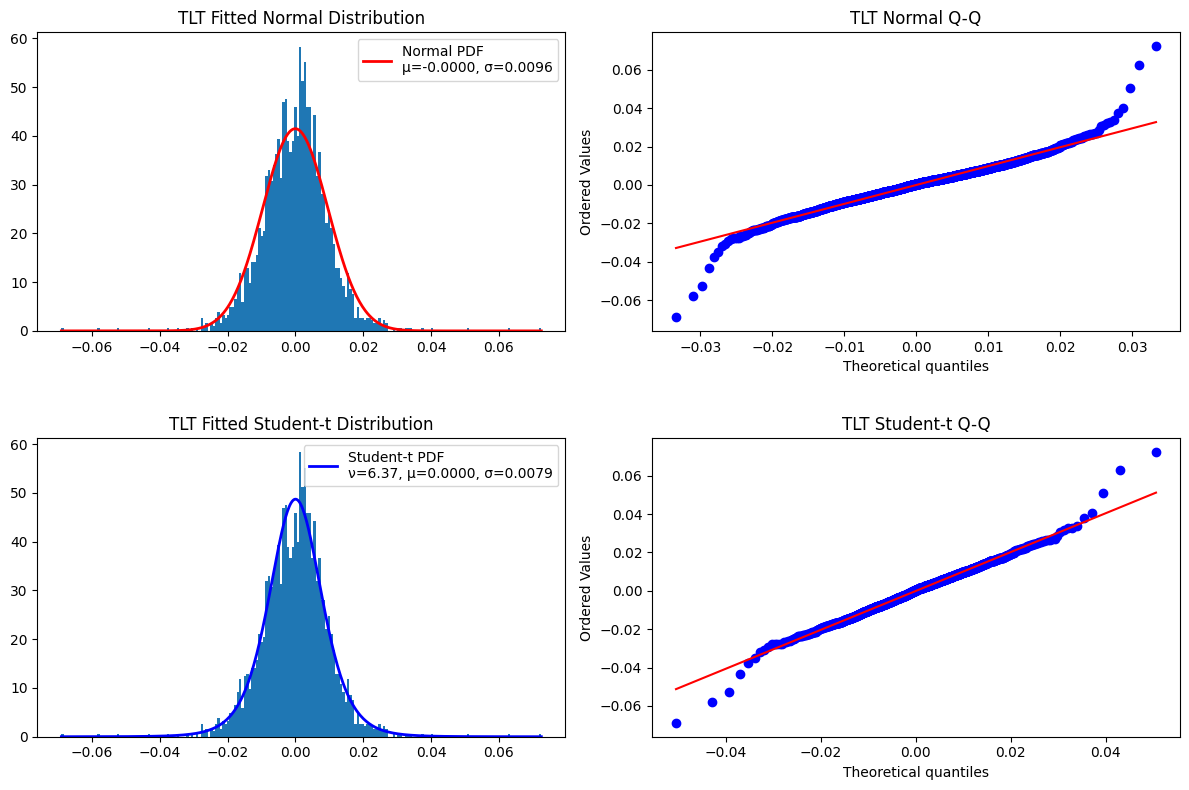

TLT Normal KS p-value: 0.002900545327926448
TLT Student-t KS p-value: 0.11426101796828159


In [25]:
fit_log_returns(log_returns, 'TLT');

We can observe from both cases that a Student-t distribution fits better, as confirmed by the higher p-values and an overall better fit in the Q-Q plot.

<Axes: ylabel='Frequency'>

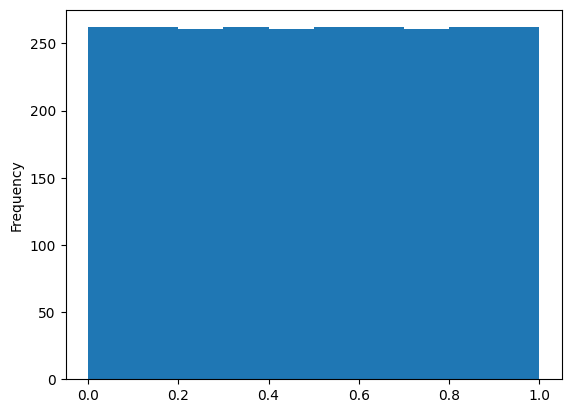

In [26]:
u_empirical = r_spy.rank(method="average") / (len(r_spy)+1)
u_empirical.plot.hist()